# SVI trend calculations

In [1]:
import pandas as pd
import numpy as np
from scripts_python import acquire, prepare, wrangle


In [ ]:
# read in history file
svi = pd.read_csv('data_csv_files/SVI_history.csv', index_col=0)

In [ ]:
svi.head()

**adding calculated columns**

In [ ]:
svi['rising'] = np.where(((svi.raw_svi2016 > svi.raw_svi2014) & (svi.raw_svi2018 > svi.raw_svi2016)), 1, 0)

In [ ]:
svi['falling'] = np.where(((svi.raw_svi2016 < svi.raw_svi2014) & (svi.raw_svi2018 < svi.raw_svi2016)), 1, 0)

In [ ]:
svi['delta'] = svi.raw_svi2018 - svi.raw_svi2014

In [ ]:
svi['avg3yr'] = (svi.raw_svi2018 + svi.raw_svi2016 + svi.raw_svi2014)/3

In [ ]:
svi['r_soci_rise'] = np.where(((svi.r_soci_total2016 > svi.r_soci_total2014) & (svi.r_soci_total2018 > svi.r_soci_total2016)), 1, 0)

In [ ]:
svi['r_comp_rise'] = np.where(((svi.r_comp_total2016 > svi.r_comp_total2014) & (svi.r_comp_total2018 > svi.r_comp_total2016)), 1, 0)

In [ ]:
svi['r_status_rise'] = np.where(((svi.r_status_total2016 > svi.r_status_total2014) & (svi.r_status_total2018 > svi.r_status_total2016)), 1, 0)

In [ ]:
svi['r_trans_rise'] = np.where(((svi.r_trans_total2016 > svi.r_trans_total2014) & (svi.r_trans_total2018 > svi.r_trans_total2016)), 1, 0)

In [ ]:
svi['r_soci_fall'] = np.where(((svi.r_soci_total2016 < svi.r_soci_total2014) & (svi.r_soci_total2018 < svi.r_soci_total2016)), 1, 0)

In [ ]:
svi['r_comp_fall'] = np.where(((svi.r_comp_total2016 < svi.r_comp_total2014) & (svi.r_comp_total2018 < svi.r_comp_total2016)), 1, 0)

In [ ]:
svi['r_status_fall'] = np.where(((svi.r_status_total2016 < svi.r_status_total2014) & (svi.r_status_total2018 < svi.r_status_total2016)), 1, 0)

In [ ]:
svi['r_trans_fall'] = np.where(((svi.r_trans_total2016 < svi.r_trans_total2014) & (svi.r_trans_total2018 < svi.r_trans_total2016)), 1, 0)

In [ ]:
svi.head()

In [ ]:
# filter to Bexar and Dallas counties
dsvi = svi[svi.county == 'Dallas']
dsvi

In [ ]:
sasvi = svi[svi.county =='Bexar']
sasvi

# SVI comparison Questions
- overall county mean for both counties by year? total?
- overall is county rising? falling? neither?
- delta for both counties?
- average scores for all raw and r columns for each county?
- how many tracks risiing? falling? neither? by county?
- other patterns?

In [ ]:
svi.columns

In [ ]:
# aggregate columns by county
raw_compdf = svi.groupby(['county'])['raw_svi2018', 'raw_svi2016', 'raw_svi2014', 'delta', 'avg3yr', 
       'r_soci_total2018', 'r_comp_total2018', 'r_status_total2018',
       'r_trans_total2018', 'r_soci_total2016', 'r_comp_total2016',
       'r_status_total2016', 'r_trans_total2016', 'r_soci_total2014',
       'r_comp_total2014', 'r_status_total2014', 'r_trans_total2014'].agg({'raw_svi2018':['min', 'max','mean'], 
                                             'raw_svi2016':['min', 'max','mean'], 
                                            'raw_svi2014':['min', 'max','mean'], 'delta':['min', 'max','mean'], 
                                             'avg3yr':['min', 'max','mean'],
                                             'r_soci_total2018':['mean'],
                                             'r_comp_total2018':['mean'], 
                                             'r_status_total2018':['mean'],
                                             'r_trans_total2018':['mean'], 
                                             'r_soci_total2016':['mean'], 
                                             'r_comp_total2016':['mean'], 
                                             'r_status_total2016':['mean'], 
                                             'r_trans_total2016':['mean'], 
                                             'r_soci_total2014':['mean'], 
                                             'r_comp_total2014':['mean'], 
                                             'r_status_total2014':['mean'], 
                                             'r_trans_total2014':['mean']})

In [ ]:
# aggregate columns by sum
sum_compdf = svi.groupby(['county'])['rising', 'falling', 'r_soci_rise', 'r_comp_rise',
       'r_status_rise', 'r_trans_rise', 'r_soci_fall', 'r_comp_fall',
       'r_status_fall', 'r_trans_fall'].agg({'rising':['sum'], 'falling':['sum'],  'r_soci_rise':['sum'], 
                                             'r_comp_rise':['sum'], 'r_status_rise':['sum'], 
                                             'r_trans_rise':['sum'], 'r_soci_fall':['sum'], 'r_comp_fall':['sum'], 
                                             'r_status_fall':['sum'], 'r_trans_fall':['sum']})

In [ ]:
# flatten column headers
raw_compdf.columns = [' '.join(col).strip() for col in raw_compdf.columns.values]
raw_compdf = raw_compdf.reset_index()

In [ ]:
# flatten column headers
sum_compdf.columns = [' '.join(col).strip() for col in sum_compdf.columns.values]
sum_compdf = sum_compdf.reset_index()

In [ ]:
# filter for only Dallas 
rd_comp = raw_compdf[raw_compdf.county == 'Dallas']
sd_comp = sum_compdf[sum_compdf.county == 'Dallas']


In [ ]:
# filter for only  Bexar
rs_comp = raw_compdf[raw_compdf.county == 'Bexar']
ss_comp = sum_compdf[sum_compdf.county == 'Bexar']

In [ ]:
# better idea, single filter for to get both counties
rbdcomp = raw_compdf[(raw_compdf.county == 'Dallas') | (raw_compdf.county == 'Bexar')]
rbdcomp

In [ ]:
# better idea, single filter for to get both counties
sbdcomp = sum_compdf[(sum_compdf.county == 'Dallas') | (sum_compdf.county == 'Bexar')]
sbdcomp

**resetting index to county**

In [ ]:
rbdcomp = rbdcomp.set_index('county')

In [ ]:
sbdcomp = sbdcomp.set_index('county')

In [ ]:
rbdcomp

In [ ]:
# add summary calculations
rbdcomp['raw_svi_mean_change18-14'] = rbdcomp['raw_svi2018 mean'] - rbdcomp['raw_svi2014 mean']
rbdcomp['r_soci_mean_change18-14'] = rbdcomp['r_soci_total2018 mean'] - rbdcomp['r_soci_total2014 mean']
rbdcomp['r_comp_mean_change18-14'] = rbdcomp['r_comp_total2018 mean'] - rbdcomp['r_comp_total2014 mean']
rbdcomp['r_status_mean_change18-14'] = rbdcomp['r_status_total2018 mean'] - rbdcomp['r_status_total2014 mean']
rbdcomp['r_trans_mean_change18-14'] = rbdcomp['r_trans_total2018 mean'] - rbdcomp['r_trans_total2014 mean']

In [ ]:
# transpose to make it easier to review side by side
Trbdcomp = rbdcomp.T

In [ ]:
Trbdcomp

In [ ]:
# read to .csv
Trbdcomp.to_csv('SVI_history_summary_rank.csv')

**Takeaways**

- nothing really jumps out here
- everything seems to be within tenths or hundredths

In [ ]:
sbdcomp

**add summary calculations**

In [ ]:
sbdcomp['num_tracts'] = [362, 527]

In [ ]:
sbdcomp['rising_pct'] = sbdcomp['rising sum']/sbdcomp['num_tracts']
sbdcomp['falling_pct'] = sbdcomp['falling sum']/sbdcomp['num_tracts']
sbdcomp['r_soci_rise_pct'] = sbdcomp['r_soci_rise sum']/sbdcomp['num_tracts']
sbdcomp['r_comp_rise_pct'] = sbdcomp['r_comp_rise sum']/sbdcomp['num_tracts']
sbdcomp['r_status_rise_pct'] = sbdcomp['r_status_rise sum']/sbdcomp['num_tracts']
sbdcomp['r_trans_rise_pct'] = sbdcomp['r_trans_rise sum']/sbdcomp['num_tracts']
sbdcomp['r_soci_fall_pct'] = sbdcomp['r_soci_fall sum']/sbdcomp['num_tracts']
sbdcomp['r_comp_fall_pct'] = sbdcomp['r_comp_fall sum']/sbdcomp['num_tracts']
sbdcomp['r_status_fall_pct'] = sbdcomp['r_status_fall sum']/sbdcomp['num_tracts']
sbdcomp['r_trans_fall_pct'] = sbdcomp['r_trans_fall sum']/sbdcomp['num_tracts']

In [ ]:
sbdcomp

In [ ]:
# transpose to make it easier to review side by side
Tsbdcomp = sbdcomp.T

In [ ]:
Tsbdcomp

In [ ]:
# read to .csv
Tsbdcomp.to_csv('SVI_history_summary_sum.csv')

**Takeaways**     
- remember, rising is bad, this means tracts are scoring higher than previous year and that means things are worse than they were before
- falling scores are good, these are areas where the community is getting LESS vulnerable over time
- 45% of the communities (tracts) in San Antonio are getting worse scores year over year from 2014 to 2018
    - vs. 39% of the communities in Dallas
- only 8% of the areas in San Antonio are seeing a year over year improvement in score
    - vs. 13% of communities in Dallas
- key grouping in San Antonio that is getting worse year over year is socioeconomic subgroup
    - San Antonio 38% getting worse vs. 30% in Dallas
    - San Antonio only 13% of areas are improving vs 19% in Dallas
- another key group difference household composition
    - San Antonio 30% getting worse vs. 25% in Dallas
    - San Antonio 23% getting better vs. 28% getting better in Dallas
    
    
**Things that might be impacting this**      
- Dallas might have programs in place that San Antonio does not to assist these at risk areas
- Redlining history and continued impact in San Antonio may be disproportionately effecting or stagnating improvements in areas in San Antonio

# redo above with only tracts in the Train dataset instead of full county

## need to run wrangle sections for SA and Dallas bellow before this will run

In [ ]:
dtrain_exp.head()

In [ ]:
dmerge = dtrain_exp[['tract']]

In [ ]:
train_exp.head()

In [ ]:
samerge = train_exp[['tract']]

In [ ]:
frames = [dmerge, samerge]
merge_tract = pd.concat(frames, axis=0)

In [ ]:
merge_tract

In [ ]:
svi.head()

In [ ]:
train_svi = svi[svi.tract.isin(merge_tract.tract)]

In [ ]:
train_svi

In [ ]:
train_svi[train_svi.county == 'Dallas'].count()

In [ ]:
train_svi[train_svi.county == 'Bexar'].count()

In [ ]:
train_svi[train_svi.county == 'Bexar'].rising.sum()

In [ ]:
train_svi[train_svi.county == 'Dallas'].rising.sum()

In [ ]:
# aggregate columns by county
traw_compdf = train_svi.groupby(['county'])['raw_svi2018', 'raw_svi2016', 'raw_svi2014', 'delta', 'avg3yr', 
       'r_soci_total2018', 'r_comp_total2018', 'r_status_total2018',
       'r_trans_total2018', 'r_soci_total2016', 'r_comp_total2016',
       'r_status_total2016', 'r_trans_total2016', 'r_soci_total2014',
       'r_comp_total2014', 'r_status_total2014', 'r_trans_total2014'].agg({'raw_svi2018':['min', 'max','mean'], 
                                             'raw_svi2016':['min', 'max','mean'], 
                                            'raw_svi2014':['min', 'max','mean'], 'delta':['min', 'max','mean'], 
                                             'avg3yr':['min', 'max','mean'],
                                             'r_soci_total2018':['mean'],
                                             'r_comp_total2018':['mean'], 
                                             'r_status_total2018':['mean'],
                                             'r_trans_total2018':['mean'], 
                                             'r_soci_total2016':['mean'], 
                                             'r_comp_total2016':['mean'], 
                                             'r_status_total2016':['mean'], 
                                             'r_trans_total2016':['mean'], 
                                             'r_soci_total2014':['mean'], 
                                             'r_comp_total2014':['mean'], 
                                             'r_status_total2014':['mean'], 
                                             'r_trans_total2014':['mean']})

In [ ]:
# aggregate columns by sum
tsum_compdf = train_svi.groupby(['county'])['rising', 'falling', 'r_soci_rise', 'r_comp_rise',
       'r_status_rise', 'r_trans_rise', 'r_soci_fall', 'r_comp_fall',
       'r_status_fall', 'r_trans_fall'].agg({'rising':['sum'], 'falling':['sum'],  'r_soci_rise':['sum'], 
                                             'r_comp_rise':['sum'], 'r_status_rise':['sum'], 
                                             'r_trans_rise':['sum'], 'r_soci_fall':['sum'], 'r_comp_fall':['sum'], 
                                             'r_status_fall':['sum'], 'r_trans_fall':['sum']})

In [ ]:
# flatten column headers
traw_compdf.columns = [' '.join(col).strip() for col in traw_compdf.columns.values]
traw_compdf = traw_compdf.reset_index()

In [ ]:
# flatten column headers
tsum_compdf.columns = [' '.join(col).strip() for col in tsum_compdf.columns.values]
tsum_compdf = tsum_compdf.reset_index()

In [ ]:
# filter for only Dallas 
trd_comp = traw_compdf[traw_compdf.county == 'Dallas']
tsd_comp = tsum_compdf[tsum_compdf.county == 'Dallas']


In [ ]:
# filter for only  Bexar
trs_comp = traw_compdf[traw_compdf.county == 'Bexar']
tss_comp = tsum_compdf[tsum_compdf.county == 'Bexar']

In [ ]:
# better idea, single filter for to get both counties
trbdcomp = traw_compdf[(traw_compdf.county == 'Dallas') | (traw_compdf.county == 'Bexar')]
trbdcomp

In [ ]:
# better idea, single filter for to get both counties
tsbdcomp = tsum_compdf[(tsum_compdf.county == 'Dallas') | (tsum_compdf.county == 'Bexar')]
tsbdcomp

**resetting index to county**

In [ ]:
trbdcomp = trbdcomp.set_index('county')

In [ ]:
tsbdcomp = tsbdcomp.set_index('county')

In [ ]:
trbdcomp

In [ ]:
# add summary calculations
trbdcomp['raw_svi_mean_change18-14'] = trbdcomp['raw_svi2018 mean'] - trbdcomp['raw_svi2014 mean']
trbdcomp['r_soci_mean_change18-14'] = trbdcomp['r_soci_total2018 mean'] - trbdcomp['r_soci_total2014 mean']
trbdcomp['r_comp_mean_change18-14'] = trbdcomp['r_comp_total2018 mean'] - trbdcomp['r_comp_total2014 mean']
trbdcomp['r_status_mean_change18-14'] = trbdcomp['r_status_total2018 mean'] - trbdcomp['r_status_total2014 mean']
trbdcomp['r_trans_mean_change18-14'] = trbdcomp['r_trans_total2018 mean'] - trbdcomp['r_trans_total2014 mean']

In [ ]:
# transpose to make it easier to review side by side
tTrbdcomp = trbdcomp.T

In [ ]:
tTrbdcomp

In [ ]:
# read to .csv
tTrbdcomp.to_csv('trainSVI_history_summary_rank.csv')

**Takeaways**

- nothing really jumps out here
- everything seems to be within tenths or hundredths

In [ ]:
tsbdcomp

**add summary calculations**

In [ ]:
tsbdcomp['num_tracts'] = [289, 246]

In [ ]:
tsbdcomp['rising_pct'] = tsbdcomp['rising sum']/tsbdcomp['num_tracts']
tsbdcomp['falling_pct'] = tsbdcomp['falling sum']/tsbdcomp['num_tracts']
tsbdcomp['r_soci_rise_pct'] = tsbdcomp['r_soci_rise sum']/tsbdcomp['num_tracts']
tsbdcomp['r_comp_rise_pct'] = tsbdcomp['r_comp_rise sum']/tsbdcomp['num_tracts']
tsbdcomp['r_status_rise_pct'] = tsbdcomp['r_status_rise sum']/tsbdcomp['num_tracts']
tsbdcomp['r_trans_rise_pct'] = tsbdcomp['r_trans_rise sum']/tsbdcomp['num_tracts']
tsbdcomp['r_soci_fall_pct'] = tsbdcomp['r_soci_fall sum']/tsbdcomp['num_tracts']
tsbdcomp['r_comp_fall_pct'] = tsbdcomp['r_comp_fall sum']/tsbdcomp['num_tracts']
tsbdcomp['r_status_fall_pct'] = tsbdcomp['r_status_fall sum']/tsbdcomp['num_tracts']
tsbdcomp['r_trans_fall_pct'] = tsbdcomp['r_trans_fall sum']/tsbdcomp['num_tracts']

In [ ]:
tsbdcomp

In [ ]:
# transpose to make it easier to review side by side
tTsbdcomp = tsbdcomp.T

In [ ]:
tTsbdcomp

In [ ]:
# read to .csv
tTsbdcomp.to_csv('trainSVI_history_summary_sum.csv')

**Takeaways**     
- remember, rising is bad, this means tracts are scoring higher than previous year and that means things are worse than they were before
- falling scores are good, these are areas where the community is getting LESS vulnerable over time
- 45% of the communities (tracts) in San Antonio are getting worse scores year over year from 2014 to 2018
    - vs. 39% of the communities in Dallas
- only 8% of the areas in San Antonio are seeing a year over year improvement in score
    - vs. 13% of communities in Dallas
- key grouping in San Antonio that is getting worse year over year is socioeconomic subgroup
    - San Antonio 38% getting worse vs. 30% in Dallas
    - San Antonio only 13% of areas are improving vs 19% in Dallas
- another key group difference household composition
    - San Antonio 30% getting worse vs. 25% in Dallas
    - San Antonio 23% getting better vs. 28% getting better in Dallas
    
    
**Things that might be impacting this**      
- Dallas might have programs in place that San Antonio does not to assist these at risk areas
- Redlining history and continued impact in San Antonio may be disproportionately effecting or stagnating improvements in areas in San Antonio

# merge Tableau datasets

In [1]:
import pandas as pd

In [2]:
# read in current csv files in use for mapping in Tableau
tsa = pd.read_csv('train_exp_wll.csv', index_col=0)
td = pd.read_csv('Dallas_train_exp_wll.csv', index_col=0)

In [3]:
tsa.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,r_status_fall,r_trans_fall,poverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled,USPS,GEOID,INTPTLAT,INTPTLONG
0,48029181821,328,8.8,1.3480,0.4879,0,0,0,0,0,...,0,0,0,0.243449,0.095138,0.096143,TX,48029181821,29.540713,-98.623809
1,48029171902,3712,25.5,2.9506,0.6394,0,0,0,0,0,...,0,0,2,0.815684,0.485412,0.435892,TX,48029171902,29.434723,-98.657214
2,48029130200,340,19.2,3.0120,0.6523,0,0,0,0,0,...,1,0,1,0.560423,0.254288,0.211310,TX,48029130200,29.415824,-98.467376
3,48029121120,143,2.7,0.8444,0.0872,0,0,0,0,0,...,0,0,0,0.243449,0.095138,0.096143,TX,48029121120,29.557548,-98.437246
4,48029120502,1766,31.8,3.4352,0.9531,0,0,0,0,0,...,0,0,2,0.815684,0.485412,0.435892,TX,48029120502,29.504533,-98.407621


In [4]:
# need a county designation
tsa['county'] = 'Bexar'

In [5]:
tsa.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,r_trans_fall,poverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled,USPS,GEOID,INTPTLAT,INTPTLONG,county
0,48029181821,328,8.8,1.3480,0.4879,0,0,0,0,0,...,0,0,0.243449,0.095138,0.096143,TX,48029181821,29.540713,-98.623809,Bexar
1,48029171902,3712,25.5,2.9506,0.6394,0,0,0,0,0,...,0,2,0.815684,0.485412,0.435892,TX,48029171902,29.434723,-98.657214,Bexar
2,48029130200,340,19.2,3.0120,0.6523,0,0,0,0,0,...,0,1,0.560423,0.254288,0.211310,TX,48029130200,29.415824,-98.467376,Bexar
3,48029121120,143,2.7,0.8444,0.0872,0,0,0,0,0,...,0,0,0.243449,0.095138,0.096143,TX,48029121120,29.557548,-98.437246,Bexar
4,48029120502,1766,31.8,3.4352,0.9531,0,0,0,0,0,...,0,2,0.815684,0.485412,0.435892,TX,48029120502,29.504533,-98.407621,Bexar


In [6]:
td.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,r_status_fall,r_trans_fall,dpoverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled,USPS,GEOID,INTPTLAT,INTPTLONG
0,48113013616,528,7.3,0.7117,0.0891,0,0,0,0,0,...,0,0,0,0.099795,0.085008,0.048500,TX,48113013616,32.955747,-96.824537
1,48113006402,1508,26.9,3.0822,0.8041,0,0,0,1,1,...,0,0,3,0.727022,0.406888,0.266358,TX,48113006402,32.727449,-96.873434
2,48113012000,1966,24.2,3.0839,0.8900,0,0,1,1,2,...,0,1,1,0.839377,0.635655,0.530122,TX,48113012000,32.755887,-96.658353
3,48113011001,2039,26.8,2.0099,0.6402,0,0,0,0,0,...,0,0,1,0.839377,0.635655,0.530122,TX,48113011001,32.681705,-96.848655
4,48113000406,1361,15.5,2.3060,0.4159,0,0,0,0,0,...,0,1,3,0.727022,0.406888,0.266358,TX,48113000406,32.835973,-96.852964


In [7]:
# need a county designation
td['county'] = 'Dallas'

In [9]:
td.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,r_trans_fall,dpoverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled,USPS,GEOID,INTPTLAT,INTPTLONG,county
0,48113013616,528,7.3,0.7117,0.0891,0,0,0,0,0,...,0,0,0.099795,0.085008,0.048500,TX,48113013616,32.955747,-96.824537,Dallas
1,48113006402,1508,26.9,3.0822,0.8041,0,0,0,1,1,...,0,3,0.727022,0.406888,0.266358,TX,48113006402,32.727449,-96.873434,Dallas
2,48113012000,1966,24.2,3.0839,0.8900,0,0,1,1,2,...,1,1,0.839377,0.635655,0.530122,TX,48113012000,32.755887,-96.658353,Dallas
3,48113011001,2039,26.8,2.0099,0.6402,0,0,0,0,0,...,0,1,0.839377,0.635655,0.530122,TX,48113011001,32.681705,-96.848655,Dallas
4,48113000406,1361,15.5,2.3060,0.4159,0,0,0,0,0,...,1,3,0.727022,0.406888,0.266358,TX,48113000406,32.835973,-96.852964,Dallas


In [10]:
# join these together into signle dataset by row
tframes = [tsa, td]
tableaudf = pd.concat(tframes, axis=0, join='outer')

In [11]:
tableaudf.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,poverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled,USPS,GEOID,INTPTLAT,INTPTLONG,county,dpoverty_cluster
0,48029181821,328,8.8,1.3480,0.4879,0,0,0,0,0,...,0.0,0.243449,0.095138,0.096143,TX,48029181821,29.540713,-98.623809,Bexar,NaN
1,48029171902,3712,25.5,2.9506,0.6394,0,0,0,0,0,...,2.0,0.815684,0.485412,0.435892,TX,48029171902,29.434723,-98.657214,Bexar,NaN
2,48029130200,340,19.2,3.0120,0.6523,0,0,0,0,0,...,1.0,0.560423,0.254288,0.211310,TX,48029130200,29.415824,-98.467376,Bexar,NaN
3,48029121120,143,2.7,0.8444,0.0872,0,0,0,0,0,...,0.0,0.243449,0.095138,0.096143,TX,48029121120,29.557548,-98.437246,Bexar,NaN
4,48029120502,1766,31.8,3.4352,0.9531,0,0,0,0,0,...,2.0,0.815684,0.485412,0.435892,TX,48029120502,29.504533,-98.407621,Bexar,NaN


In [12]:
# write new df to csv for Tableau
#tableaudf.to_csv('tableuadf.csv')

# RUN here before section 3 will run

## create San Antonio .csv for Tableau mapping

In [2]:

import pandas as pd
import seaborn as sns

from scripts_python import wrangle
from scripts_python import explore
from scripts_python import model_MAE, model_classification

import matplotlib.pyplot as plt
import numpy as np


from math import sqrt
from scipy import stats

In [3]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(289, 40) (73, 40)


   k        sse
0  1  35.748849
1  2  13.664196
2  3   8.691464
3  4   6.753261
4  5   5.757310
5  6   5.058590
6  7   4.511127
7  8   3.981380
8  9   3.565583


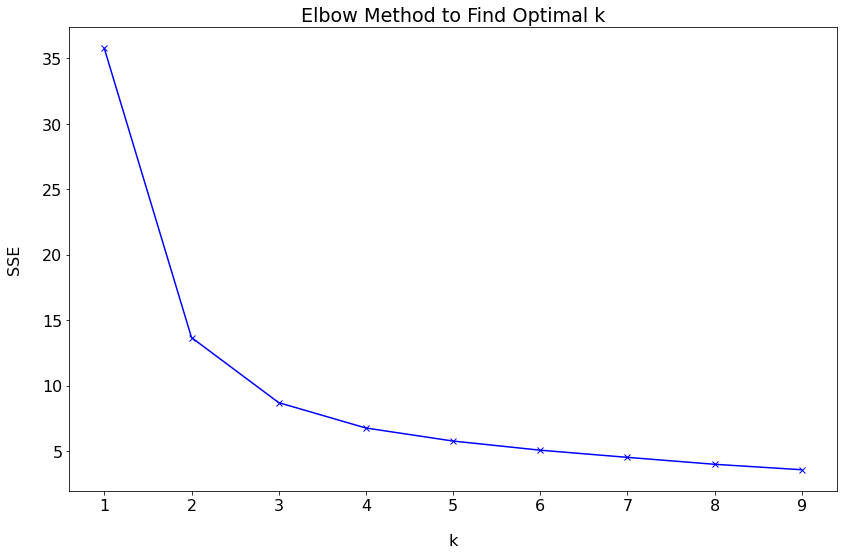

In [4]:
cluster_vars = ['spl_theme1_scaled', 'ep_pov_scaled', 'e_pov_scaled']
explore.elbow_plot(X_train_scaled, cluster_vars)

In [5]:
train_clusters, kmeans = explore.run_kmeans(train_exp, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'poverty_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'poverty_cluster')

In [6]:

train_clusters, kmeans = explore.run_kmeans(train_exp, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'poverty_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'poverty_cluster')

In [7]:

centroids = explore.get_centroids(cluster_vars, cluster_col_name='poverty_cluster', kmeans= kmeans)

In [8]:

train_exp = explore.add_to_train(train_clusters, centroids, train_exp, cluster_col_name = 'poverty_cluster')

In [9]:
# export train_exp for Tableau
#train_exp.to_csv('train_exp_mapping.csv')

In [10]:
train_exp.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,r_status_rise,r_trans_rise,r_soci_fall,r_comp_fall,r_status_fall,r_trans_fall,poverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled
289,48029181821,328,8.8,1.3480,0.4879,0,0,0,0,0,...,0,0,0,0,0,0,0,0.243449,0.095138,0.096143
200,48029171902,3712,25.5,2.9506,0.6394,0,0,0,0,0,...,0,0,0,1,0,0,2,0.815684,0.485412,0.435892
69,48029130200,340,19.2,3.0120,0.6523,0,0,0,0,0,...,0,0,0,0,1,0,1,0.560423,0.254288,0.211310
29,48029121120,143,2.7,0.8444,0.0872,0,0,0,0,0,...,1,0,1,0,0,0,0,0.243449,0.095138,0.096143
12,48029120502,1766,31.8,3.4352,0.9531,0,0,0,0,0,...,1,1,0,0,0,0,2,0.815684,0.485412,0.435892


In [11]:
long_lat = pd.read_csv('FIPS_long_lat.csv')

In [12]:
long_lat

,USPS,GEOID,INTPTLAT,INTPTLONG
0,TX,48001950100,31.971468,-95.552444
1,TX,48001950401,31.734637,-95.815710
2,TX,48001950402,31.800052,-95.913110
3,TX,48001950500,31.787885,-95.640537
4,TX,48001950600,31.750205,-95.669209
...,...,...,...,...
5260,TX,48505950400,26.996981,-99.182603
5261,TX,48507950100,28.957194,-99.612423
5262,TX,48507950200,28.980591,-99.952092
5263,TX,48507950301,28.761956,-99.790649


In [13]:
merge_ll_train = pd.merge(train_exp, long_lat, left_on='tract', right_on='GEOID', how='left')

In [14]:
merge_ll_train.head()

,tract,e_pov,ep_pov,spl_theme1,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,...,r_status_fall,r_trans_fall,poverty_cluster,centroid_spl_theme1_scaled,centroid_ep_pov_scaled,centroid_e_pov_scaled,USPS,GEOID,INTPTLAT,INTPTLONG
0,48029181821,328,8.8,1.3480,0.4879,0,0,0,0,0,...,0,0,0,0.243449,0.095138,0.096143,TX,48029181821,29.540713,-98.623809
1,48029171902,3712,25.5,2.9506,0.6394,0,0,0,0,0,...,0,0,2,0.815684,0.485412,0.435892,TX,48029171902,29.434723,-98.657214
2,48029130200,340,19.2,3.0120,0.6523,0,0,0,0,0,...,1,0,1,0.560423,0.254288,0.211310,TX,48029130200,29.415824,-98.467376
3,48029121120,143,2.7,0.8444,0.0872,0,0,0,0,0,...,0,0,0,0.243449,0.095138,0.096143,TX,48029121120,29.557548,-98.437245
4,48029120502,1766,31.8,3.4352,0.9531,0,0,0,0,0,...,0,0,2,0.815684,0.485412,0.435892,TX,48029120502,29.504533,-98.407621


In [15]:
# export train_exp for Tableau
merge_ll_train.to_csv('train_exp_wll.csv')

## create Dallas .csv for Tableau

In [16]:
ddf, dtrain_exp, dX_train_scaled, dy_train, dX_test_scaled, yd_test = wrangle.wrangle_dallas_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(246, 40) (62, 40)


In [17]:
dcluster_vars = ['spl_theme1_scaled', 'ep_pov_scaled', 'e_pov_scaled']
#explore.elbow_plot(dX_train_scaled, cluster_vars)

In [18]:

dtrain_clusters, dkmeans = explore.run_kmeans(dtrain_exp, dX_train_scaled, k=4, cluster_vars=dcluster_vars, cluster_col_name = 'dpoverty_cluster')


In [19]:
dcentroids = explore.get_centroids(dcluster_vars, cluster_col_name='dpoverty_cluster', kmeans= dkmeans)

In [20]:
dtrain_exp = explore.add_to_train(dtrain_clusters, dcentroids, dtrain_exp, cluster_col_name = 'dpoverty_cluster')


In [21]:
dmerge_ll_train = pd.merge(dtrain_exp, long_lat, left_on='tract', right_on='GEOID', how='left')

In [22]:
# export train_exp for Tableau
dmerge_ll_train.to_csv('Dallas_train_exp_wll.csv')

In [25]:
dtrain_exp.columns

Index(['tract', 'e_pov', 'ep_pov', 'spl_theme1', 'raw_svi', 'f_pov_soci',
       'f_unemp_soci', 'f_pci_soci', 'f_nohsdp_soci', 'f_soci_total',
       'f_age65_comp', 'f_age17_comp', 'f_disabl_comp', 'f_sngpnt_comp',
       'f_comp_total', 'f_minrty_status', 'f_limeng_status', 'f_status_total',
       'f_munit_trans', 'f_mobile_trans', 'f_crowd_trans', 'f_noveh_trans',
       'f_groupq_trans', 'f_trans_total', 'all_flags_total', 'zip',
       'tract_cases_per_100k', 'bin_svi', 'rank_svi', 'rising', 'falling',
       'delta', 'avg3yr', 'r_soci_rise', 'r_comp_rise', 'r_status_rise',
       'r_trans_rise', 'r_soci_fall', 'r_comp_fall', 'r_status_fall',
       'r_trans_fall', 'dpoverty_cluster', 'centroid_spl_theme1_scaled',
       'centroid_ep_pov_scaled', 'centroid_e_pov_scaled'],
      dtype='object')

# create SVI rank bins

In [23]:
svi_features = svi[['tract', 'rising', 'falling', 'delta', 'avg3yr', 
                    'r_soci_rise', 'r_comp_rise', 'r_status_rise', 'r_trans_rise', 
                   'r_soci_fall', 'r_comp_fall', 'r_status_fall', 'r_trans_fall']]

NameError: name 'svi' is not defined

In [ ]:
svi_features.head()

In [ ]:
svi_features.to_csv('svi_features.csv')

In [ ]:
# merge svi features to df after prepare, before split and scale
df2split = pd.merge(df, svi_features, on='tract')

In [ ]:
df2split

In [ ]:
svi['rank_svi'] = pd.cut(svi.raw_svi2018, bins = [0, .27, .5, .75, 1], labels = [4, 3, 2, 1])

In [ ]:
stdvev1 = svi[svi.rank_svi == 1].raw_svi2018.std()
stdvev1

In [ ]:
stdvev2 = svi[svi.rank_svi == 2].raw_svi2018.std()
stdvev2

In [ ]:
stdvev3 = svi[svi.rank_svi == 3].raw_svi2018.std()
stdvev3

In [ ]:
stdvev4 = svi[svi.rank_svi == 4].raw_svi2018.std()
stdvev4

# creating SVI history.csv

- get 2018, 2016, 2014 historical SVI data .csv
    - note: 2010 is not available sorted by state
    - need to watch for possible issues with tract/FIPS changes creating null values
- get the rank/raw score for each theme and total by census track for each year available
- merge these back together on FIPS and watch for nulls
- change up or down from previous year
- stddev
- %/amount change year over year?


Groupings/Themes
- theme1 = socioeconomic status
- theme2 = household composition and disability
- theme3 = minority and language status
- theme4 = housing type and transportation


- NOTE: excluding 2010 because shape and columns in .csv are substantially different, will only got back to 2014

In [ ]:
# get 2018 by census tract
SVI2018 = pd.read_csv('data_csv_files/SVI2018_US.csv')

In [ ]:
SVI2018.head()

In [ ]:
# filter for just TX
SVI2018 = SVI2018[SVI2018.STATE == 'TEXAS']

In [ ]:
SVI2018.head()

In [ ]:
# get list of all raw/rank SVI score columns
rpl_list18 = [col for col in SVI2018.columns if col.startswith('R')]

In [ ]:
rpl_list18

In [ ]:
# create dataframe with just the raw/rank score columns
df2018 = SVI2018[[c for c in SVI2018.columns if c in rpl_list18]]

In [ ]:
# rename columns
df2018.rename(columns = {'RPL_THEMES': 'raw_svi2018', 
                     "RPL_THEME1": "r_soci_total2018", 
                     "RPL_THEME2": "r_comp_total2018", 
                     "RPL_THEME3": "r_status_total2018", 
                     "RPL_THEME4": "r_trans_total2018"}, inplace = True)

In [ ]:
# add back county, FIPS, population
df2018['county'] = SVI2018.COUNTY
df2018['tract'] = SVI2018.FIPS
df2018['est_population2018'] = SVI2018.E_TOTPOP

In [ ]:
df2018.head()

In [ ]:
df2018.shape

In [ ]:
# note 2016 is already filtered down to TX only
SVI2016 = pd.read_csv('data_csv_files/TX_SVI_census2016.csv')

In [ ]:
SVI2016.head()

In [ ]:
rpl_list16 = [col for col in SVI2016.columns if col.startswith('R')]

In [ ]:
rpl_list16

In [ ]:
# create dataframe with just the raw/rank score columns
df2016 = SVI2016[[c for c in SVI2016.columns if c in rpl_list16]]

In [ ]:
# rename columns
df2016.rename(columns = {'RPL_THEMES': 'raw_svi2016', 
                     "RPL_THEME1": "r_soci_total2016", 
                     "RPL_THEME2": "r_comp_total2016", 
                     "RPL_THEME3": "r_status_total2016", 
                     "RPL_THEME4": "r_trans_total2016"}, inplace = True)

In [ ]:
# add back county, FIPS, population
#df2016['county2016'] = SVI2016.COUNTY
df2016['tract'] = SVI2016.FIPS
df2016['est_population2016'] = SVI2016.E_TOTPOP

In [ ]:
df2016.head()


In [ ]:
df2016.shape

In [ ]:
# note 2014 is already filtered down to TX only
SVI2014 = pd.read_csv('TX_SVI_census2014.csv')

In [ ]:
rpl_list14 = [col for col in SVI2014.columns if col.startswith('R')]
rpl_list14

In [ ]:
# create dataframe with just the raw/rank score columns
df2014 = SVI2014[[c for c in SVI2014.columns if c in rpl_list14]]

In [ ]:
# rename columns
df2014.rename(columns = {'RPL_THEMES': 'raw_svi2014', 
                     "RPL_THEME1": "r_soci_total2014", 
                     "RPL_THEME2": "r_comp_total2014", 
                     "RPL_THEME3": "r_status_total2014", 
                     "RPL_THEME4": "r_trans_total2014"}, inplace = True)

In [ ]:
# add back county, FIPS, population
#df2014['county2014'] = SVI2014.COUNTY
df2014['tract'] = SVI2014.FIPS
df2014['est_population2014'] = SVI2014.E_TOTPOP

In [ ]:
df2014.head()


In [ ]:
df2014.shape

In [ ]:
# get 2010 by census tract
SVI2010 = pd.read_csv('SVI2010_US.csv')

In [ ]:
# DO NOT USE - not worth time to sort
SVI2010.head()

In [ ]:
# merge the 2018, 2016, and 2014 dateframes on census_tract
# all are same shape = (5254, 8), use left merge just in case so don't lose any 2018 data
SVI_hist = pd.merge(df2018, df2016, on='tract', how='left')

In [ ]:
SVI_hist.shape

In [ ]:
SVI_hist.columns

In [ ]:
SVI_hist_full = pd.merge(SVI_hist, df2014, on='tract', how='left')

In [ ]:
SVI_hist_full.shape

In [ ]:
SVI_hist_full.head()

In [ ]:
# now drop any -999.0 observations, per CDC these were removed during ranking
SVI_hist_full = SVI_hist_full[SVI_hist_full.raw_svi2018 != -999.0]

In [ ]:
SVI_hist_full.head()

In [ ]:
SVI_hist_full.shape

In [ ]:
SVI_hist_full.columns

In [ ]:
svi_histdf = SVI_hist_full[['county', 'tract', 'raw_svi2018', 'raw_svi2016', 'raw_svi2014', 
               'r_soci_total2018', 'r_comp_total2018', 'r_status_total2018', 'r_trans_total2018',
              'r_soci_total2016', 'r_comp_total2016', 'r_status_total2016', 'r_trans_total2016', 
              'r_soci_total2014', 'r_comp_total2014', 'r_status_total2014', 'r_trans_total2014',
              'est_population2018', 'est_population2016', 'est_population2014']]

In [ ]:
svi_histdf.head()

In [ ]:
# write combined file to csv
svi_histdf.to_csv('SVI_history.csv')

In [ ]:
# test wrangle
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_data()

In [ ]:
sa = acquire.get_san_antonio_data()

In [ ]:
sa.head()

In [ ]:
sasvi = acquire.get_sa_svi_data()

In [ ]:
sasvi.head()

In [ ]:
huddf = acquire.get_HUD(sasvi)

In [ ]:
huddf.head()

In [ ]:
huddf.shape

In [ ]:
merge_bexar = sa[['zip', 'population', 'positive', 'casesp100000']]

In [ ]:
svi_zip = pd.merge(sasvi, huddf, on='tract', how='left')

In [ ]:
svi_zip.isna().sum()


In [ ]:
svi_zip.shape

In [ ]:
svi_zip_cases = pd.merge(svi_zip, merge_bexar, on='zip', how='left')

In [ ]:
svi_zip_cases.head()

In [ ]:
svi_zip_cases.isna().sum()

In [ ]:
svi_zip_cases.shape

# testing functions for acquire and prepare

In [ ]:
# testing
df = acquire.run()
df = prepare.prepare_data(df)
df.head()

In [ ]:
df.columns

In [ ]:
# full acquire test
df = acquire.run()

In [ ]:
# test acquire import Bexar data
bexar = acquire.get_san_antonio_data()
bexar.head()

In [ ]:
# test acquire import svi data
svi = acquire.get_svi_data()
svi.head()

In [ ]:
# test acquire get HUD merge df
merge_HUD = acquire.get_HUD(bexar)

In [ ]:
merge_HUD.head()

# creating functions to merge SVI with HUD and cases

In [ ]:
# import Bexar cases dataframe
bexar_cases = pd.read_csv('Bexar_County_COVID-19_Data_by_Zip_Code.csv', index_col=0)
bexar_cases.columns = bexar_cases.columns.str.lower()
bexar_cases.head()

In [ ]:
bexar_cases.info()

In [ ]:
# how many unique zip codes are in the cases df?
bexar_cases.nunique()

In [ ]:
# import san antonio svi index dataframe
svidf = pd.read_csv('san_antonio_2018_tract.csv')
svidf.columns = svidf.columns.str.lower()
svidf = svidf.rename(columns={'fips': 'tract'})
svidf.head()

In [ ]:
# how many unique FIPS ids are in the svi df?
svidf.tract.value_counts()

In [ ]:
# get list of unique zip codes in the bexar cases df
bexar_zip = bexar_cases.zip_code.tolist()

In [ ]:
# import track to zip dataframe
zips = pd.read_csv('TRACT_ZIP_122018_78s_only.csv')
# filter the zips df to only those in the bexar zip list
zips = zips[zips.zip.isin(bexar_zip)]
zips

In [ ]:
# view zips sorted by tract and total ratio
zips.sort_values(by=['tract', 'tot_ratio'], ascending=[True, False]).head()

In [ ]:
# verify that .08 is highest for tract 48493000201
zips[zips.tract == 48493000201]

In [ ]:
# aggregate the data frame to get the zip code with the max ratio by tract
zipsdf = zips.groupby(['tract'])['tot_ratio', 'zip'].agg({'tot_ratio':['max'], 'zip':['first']})
zipsdf.columns = [' '.join(col).strip() for col in zipsdf.columns.values]
zipsdf = zipsdf.reset_index()

In [ ]:
zipsdf.head()

In [ ]:
# the svi only has 366 rows, hopefully they are all in this list
len(zipsdf)

In [ ]:
# create merge df to test merging
merge_zip3 = zipsdf[['tract', 'zip first']]

In [ ]:
merge_zip3 = merge_zip3.rename(columns={'zip first':'zip'})

In [ ]:
merge_zip3

In [ ]:
# create new df merging svi and 2nd merge zip file on tract
svi_zip2 = pd.merge(svidf, merge_zip3, on='tract', how='left')
svi_zip2.shape

In [ ]:
# check for nulls
svi_zip2.isna().sum()

In [ ]:
# create dataframe to merge with svi
merge_bexar = bexar[['zip', 'population', 'positive', 'casesp100000']]
merge_bexar.head()

In [ ]:
# merge svi_zip with merge_bexar
full = pd.merge(svi_zip2, merge_bexar, on='zip', how='left')
full.head()

In [ ]:
max_ratio = zips.groupby('tract')[['tot_ratio']].max()

In [ ]:
max_ratio = max_ratio.reset_index()

In [ ]:
max_ratio.head()

In [ ]:
max_ratio.nunique()

In [ ]:
zips[zips.zip == 78219]

In [ ]:
# requiring the total ratio to be 54% or higher per track gives the closest to 366 without going over
# there will be 4 zip codes not represented and 2 census tracks not represented
# when merged we should get null values for these
zip_54 = zips[zips.tot_ratio >= .54]
zip_54.nunique()

In [ ]:
# create df with only values to merge
merge_zip = zip_54[['tract', 'zip']]
merge_zip

In [ ]:
# create new df merging svi and merge zip on tract
fulldf = pd.merge(svidf, merge_zip, on='tract', how='left')
fulldf.shape

In [ ]:
# will need to convert zip to int
type(fulldf.zip[0])

In [ ]:
# there are 21 tract ids that do not have a zip code
fulldf.isna().sum()

In [ ]:
# create a df of just the row with a null zip code
missing_zip = fulldf[fulldf.zip.isna()]

In [ ]:
missing_zip

In [ ]:
# here is a list of the tracts missing zip codes
missing_zip.tract.value_counts()

In [ ]:
# find value for 48029131802
zips[zips.tract == 48029131802]
# assign 78101 to this track = highest % addresses

In [ ]:
# find value for 48029182103
zips[zips.tract == 48029182103]
# assign 78023 to this track = highest % addresses

In [ ]:
# find value for 48029980004
zips[zips.tract == 48029980004]
# assign 78216 to this track = highest % addresses

In [ ]:
# find value for 48029130402
zips[zips.tract == 48029130402]
# assign 78210 to this track = highest % addresses

In [ ]:
# find value for 48029141900
zips[zips.tract == 48029141900]
# assign 78263 to this track = highest % addresses

In [ ]:
# find value for 48029191503
zips[zips.tract == 48029191503]
# assign 78249 to this track = highest % addresses

In [ ]:
# find value for 48029181704
zips[zips.tract == 48029181704]
# assign 78238 to this track = highest % addresses

In [ ]:
# find value for 48029131700
zips[zips.tract == 48029131700]
# assign 78148 to this track = highest % addresses

In [ ]:
# find value for 48029121205
zips[zips.tract == 48029121205]
# assign 78233 to this track = highest % addresses

In [ ]:
# find value for 48029110100
zips[zips.tract == 48029110100]
# assign 78205 to this track = highest % addresses

In [ ]:
# find value for 48029182102
zips[zips.tract == 48029182102]
# assign 78255 to this track = highest % addresses

In [ ]:
# find value for 48029192100
zips[zips.tract == 48029192100]
# assign 78204 to this track = highest % addresses

In [ ]:
# find value for 48029121905
zips[zips.tract == 48029121905]
# assign 78259 to this track = highest % addresses

In [ ]:
# find value for 48029130800
zips[zips.tract == 48029130800]
# assign 78219 to this track = highest % addresses

In [ ]:
# find value for 48029121203
zips[zips.tract == 48029121203]
# assign 78233 to this track = highest % addresses

In [ ]:
# find value for 48029171602
zips[zips.tract == 48029171602]
# assign 78227 to this track = highest % addresses

In [ ]:
# find value for 48029181725
zips[zips.tract == 48029181725]
# assign 78251 to this track = highest % addresses

In [ ]:
# find value for 48029150300
zips[zips.tract == 48029150300]
# assign 78214 to this track = highest % addresses

In [ ]:
# find value for 48029191504
zips[zips.tract == 48029191504]
# assign 78231 to this track = highest % addresses

In [ ]:
# find value for 48029191004
zips[zips.tract == 48029191004]
# assign 78216 to this track = highest % addresses

In [ ]:
# find value for 48029130500
zips[zips.tract == 48029130500]
# assign 78202 to this track = highest % addresses

In [ ]:
tracts_list = missing_zip.tract.tolist()

In [ ]:
assign_zip_list = [78101, 78023, 78216, 78210, 78263, 78249, 78238, 78148, 78233, 78205, 78255, 78204, 78259,
                   78219, 78233, 78227, 78251, 78214, 78231, 78216, 78202]

In [ ]:
len(tracts_list)

In [ ]:
len(assign_zip_list)

In [ ]:
# verified lists are same length, now zip lists together into df to merge back to fulldf
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/#:~:text=Create%20pandas%20dataframe%20from%20lists%20using%20zip%20Second,it%20to%20produce%20one%20item%20at%20a%20time.
data_to_add = pd.DataFrame()
data_to_add['tract'] = tracts_list
data_to_add['zip'] = assign_zip_list
data_to_add

In [ ]:
# add these values to the merge zip df
merge_zip2 = merge_zip.append(data_to_add)

In [ ]:
len(merge_zip2)

In [ ]:
# create new df merging svi and 2nd merge zip file on tract
svi_zip = pd.merge(svidf, merge_zip2, on='tract', how='left')
svi_zip.shape

In [ ]:
# check for nulls
svi_zip.isna().sum()

In [ ]:
svi_zip.head()

In [ ]:
bexar_cases.head()

In [ ]:
# rename the zip code column to merge on
bexar_cases = bexar_cases.rename(columns={'zip_code': 'zip', 'populationtotals_totpop_cy': 'population'})

In [ ]:
bexar_cases

In [ ]:
# create dataframe to merge with svi
merge_bexar = bexar_cases[['zip', 'population', 'positive', 'casesp100000']]
merge_bexar.head()

In [ ]:
# merge svi_zip with merge_bexar
svi_zip_cases = pd.merge(svi_zip, merge_bexar, on='zip', how='left')
svi_zip_cases.head()

In [ ]:
# check for nulls
svi_zip_cases.isna().sum()

In [ ]:
# write final compliation to csv
#svi_zip_cases.to_csv('full_san_antonio.csv')